In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
import requests
import missingno as msno

In [2]:
import tensorflow as tf
tf.__version__

'2.13.0'

In [7]:
x_features = pd.read_excel("Features data set.xlsx") # features
y_sales = pd.read_excel('sales data-set.xlsx') # labels
z_stores = pd.read_csv("stores data-set.csv") #stores

In [8]:
print(x_features.head())
print(y_sales.head())
print(z_stores.head())
print('-'*40)
print('\n')

   Store       Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  \
0      1 2010-02-05        42.31       2.572        NaN        NaN        NaN   
1      1 2010-02-12        38.51       2.548        NaN        NaN        NaN   
2      1 2010-02-19        39.93       2.514        NaN        NaN        NaN   
3      1 2010-02-26        46.63       2.561        NaN        NaN        NaN   
4      1 2010-03-05        46.50       2.625        NaN        NaN        NaN   

   MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN  211.289143         8.106      False  
3        NaN        NaN  211.319643         8.106      False  
4        NaN        NaN  211.350143         8.106      False  
   Store  Dept       Date  Weekly_Sales  IsHoliday
0      1     1 2010-02-05      24924.50      False
1      1     1 2010-02-12      46

In [9]:
# First - Optimize the sales via store in a unique date with all Deparments to be preper
y_sales['Date'] = pd.to_datetime(y_sales['Date'])
# we have to repeat its again to fit x_features y_sales
y_sales = y_sales.groupby(['Store', 'Date']).sum()
# Merging of x_features and z_stores
x_features = pd.merge(x_features, z_stores)

In [10]:
# Secondly I  transform categorical 'Type' column' feature needed to be number.
def Type2num(x):
     if x == 'A':
         return 0
     if x == 'B':
         return 1
     if x == 'C':
         return 2
x_features['Type'] = x_features['Type'].apply(Type2num)


x_features['Date'] = pd.to_datetime(x_features['Date'])
x_features = x_features.groupby(['Store', 'Date']).sum()
print(x_features.dtypes)
print(y_sales.dtypes)
print(z_stores.dtypes)

Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
IsHoliday         int64
Type              int64
Size              int64
dtype: object
Dept              int64
Weekly_Sales    float64
IsHoliday         int64
dtype: object
Store     int64
Type     object
Size      int64
dtype: object


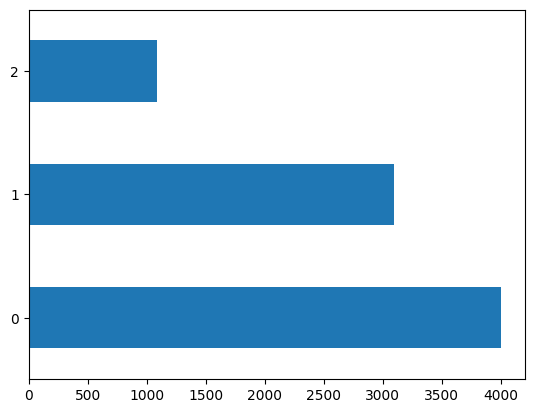

In [11]:
x_features['Type'].value_counts() #categorical variable
x_features.Type.value_counts().plot.barh();

In [12]:
Combined_table = pd.merge(x_features, y_sales['Weekly_Sales'], how='inner', right_index=True, left_index=True)
Combined_table.isna().sum()
Combined_table.info
Combined_table['Weekly_Sales'].describe()

# Very well... It seems that your minimum price is larger than zero. Excellent!

count    6.435000e+03
mean     1.046965e+06
std      5.643666e+05
min      2.099862e+05
25%      5.533501e+05
50%      9.607460e+05
75%      1.420159e+06
max      3.818686e+06
Name: Weekly_Sales, dtype: float64

In [13]:
# Adding a colum and calculating profit per m^2
Combined_table['M^2_per_profit'] = Combined_table['Weekly_Sales']/Combined_table['Size']
Combind_graf = Combined_table.copy()

<Axes: >

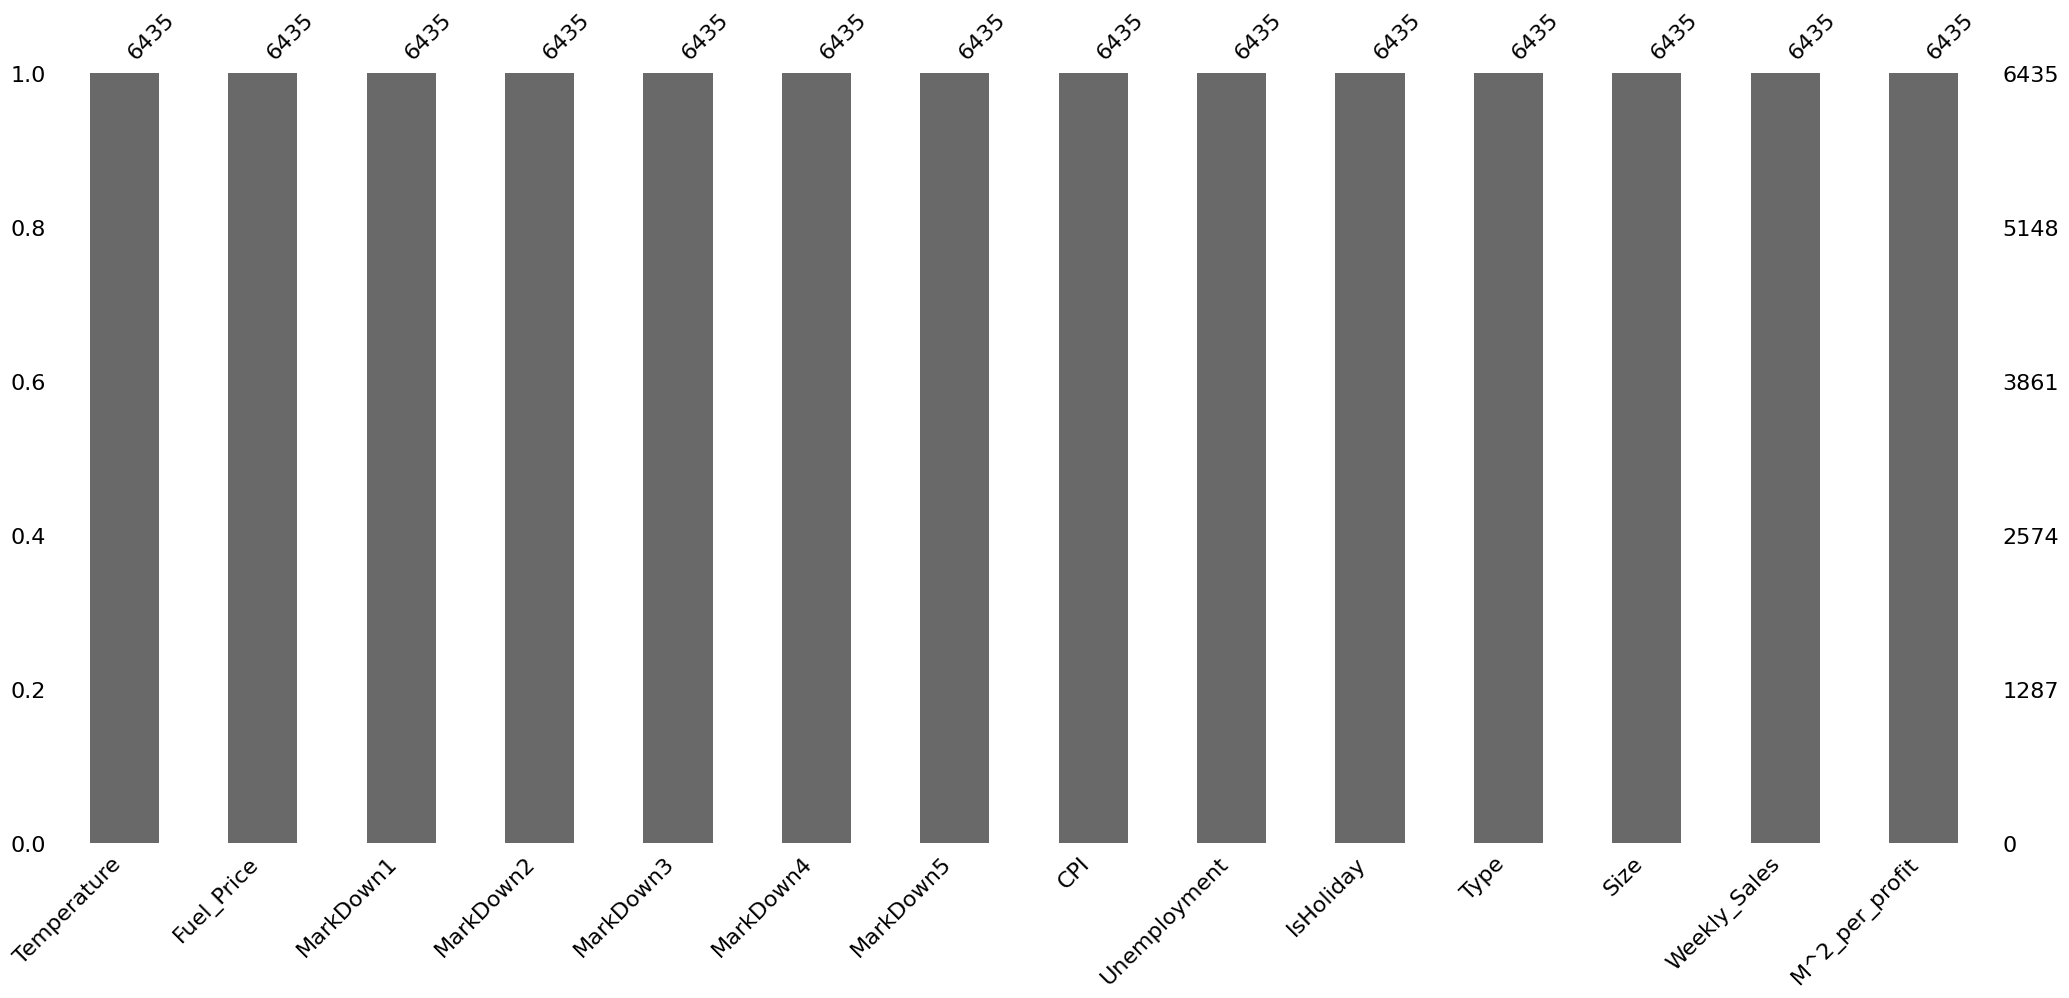

In [14]:
Combined_table.isnull().sum()
Combined_table.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
msno.bar(Combined_table)   # checking for null ? by plotting.

In [15]:
print("Skewness: %f" % Combined_table['Weekly_Sales'].skew())
print("Kurtosis: %f" % Combined_table['Weekly_Sales'].kurt())

Skewness: 0.668362
Kurtosis: 0.053141


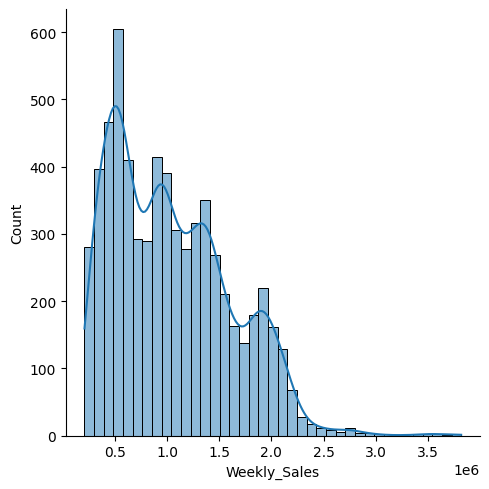

In [16]:
# let see how Weekly_Sales corellative to other features ?
# sns.distplot(Combined_table['Weekly_Sales'])
sns.displot(data = Combined_table, x = 'Weekly_Sales', kde=True)


In [25]:
print("Dats shape = {}".format(Combined_table.shape))
print()
print("Lets see some feature:")
print(Combined_table[1:10])

Dats shape = (6435, 14)

Lets see some feature:
            Store  Temperature  Fuel_Price  MarkDown2  MarkDown3  MarkDown4  \
Date                                                                          
2010-02-12      1        38.51       2.548        0.0        0.0        0.0   
2010-02-19      1        39.93       2.514        0.0        0.0        0.0   
2010-02-26      1        46.63       2.561        0.0        0.0        0.0   
2010-03-05      1        46.50       2.625        0.0        0.0        0.0   
2010-03-12      1        57.79       2.667        0.0        0.0        0.0   
2010-03-19      1        54.58       2.720        0.0        0.0        0.0   
2010-03-26      1        51.45       2.732        0.0        0.0        0.0   
2010-04-02      1        62.27       2.719        0.0        0.0        0.0   
2010-04-09      1        65.86       2.770        0.0        0.0        0.0   

            MarkDown5         CPI  Unemployment  IsHoliday  Type    Size  \
Date  

In [23]:
# Definition of Y (label) and X (inputs)
# Define label for the new merge table: "combined_table"
# The 'Weekly_Sales' is Indexial so it dosn't take as a label
y = Combined_table['Weekly_Sales']
# Define features for the new merge table: "combined_table"
x = Combined_table.drop(['Weekly_Sales'], axis=1)

In [24]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
y.shape
y = y.values.reshape(6435, 1)
y_scaled = scaler.fit_transform(y)
x.head()
x.tail()

,Store,Temperature,Fuel_Price,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,M^2_per_profit
Date,,,,,,,,,,,,,
2012-09-28,45,64.88,3.997,20.64,1.50,1601.01,3288.25,192.013558,8.684,0,1,118221,6.032549
2012-10-05,45,64.89,3.985,0.00,18.82,2253.43,2340.01,192.170412,8.667,0,1,118221,6.204101
2012-10-12,45,54.47,4.000,0.00,7.89,599.32,3990.54,192.327265,8.667,0,1,118221,6.212639
2012-10-19,45,56.47,3.969,0.00,3.18,437.73,1537.49,192.330854,8.667,0,1,118221,6.074433
2012-10-26,45,58.85,3.882,58.08,100.00,211.94,858.33,192.308899,8.667,0,1,118221,6.431018


In [26]:
# we need to take x_scaled after being notmalized
# In the first step we will split the data in training and remaining dataset
# random_state = 0 to keep order time as best as I can
x_train, x_valid, y_train, y_valid = train_test_split(x_scaled, y, train_size=0.80, random_state=0)

In [27]:
# Now since we want the valid and test size to be equal (10% each of overall data).
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
x_test, x_valid, y_test, y_valid = train_test_split(x_scaled,y, test_size=0.5)
# Finally splitting will be : 80%-10%-10% as train-val-test

In [28]:
x_train = x_train.reshape(x_train.shape[0],1,x_train.shape[1])
x_valid = x_valid.reshape(x_valid.shape[0],1,x_valid.shape[1])
x_test = x_test.reshape(x_test.shape[0],1,x_test.shape[1])

Test_Data = (x_test, y_test)
print(x_train.shape), print(y_train.shape)
print(x_valid.shape), print(y_valid.shape)
print(x_test.shape), print(y_test.shape)

(5148, 1, 13)
(5148, 1)
(3218, 1, 13)
(3218, 1)
(3217, 1, 13)
(3217, 1)


(None, None)

In [108]:
# Training basic LSTM model# Initializing the Recurrent Neural Network AS LSTM
inputs = tf.random.normal([32, 50, 11])
model = Sequential()

In [109]:
# Adding the first LSTM layer with a sigmoid activation function and some
# Dropout regularization
# Units - dimensionality of the output space
model.add(LSTM(units = 32, return_sequences = False, input_shape =(1,x_train.shape[2])))
# Adding the output layer
model.add(Dense(units = 128, activation="relu"))
model.add(Dense(units = 64, activation="relu"))
model.add(Dense(units = 1, activation="relu", input_shape=(4,)))
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                5888      
                                                                 
 dense_7 (Dense)             (None, 128)               4224      
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18433 (72.00 KB)
Trainable params: 18433 (72.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [95]:
import tensorflow as tf

# Define the optimizer with decay
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

# Define a custom metric function (for example, soft_acc)
def soft_acc(y_true, y_pred):
    # Define your custom metric calculation here
    return ...  # Replace this with your metric calculation

# Create a model
model = tf.keras.Sequential()
# Add layers to your model here

# Compile the model with the optimizer
model.compile(optimizer=opt, loss='...')  # Replace '...' with your chosen loss function

# Create a custom metric layer
class SoftAcc(tf.keras.layers.Layer):
    def __init__(self, name='soft_acc', **kwargs):
        super(SoftAcc, self).__init__(name=name, **kwargs)

    def call(self, y_true, y_pred):
        return soft_acc(y_true, y_pred)

# Add the custom metric layer to the model
model.add(SoftAcc())

# Now you can use this model for training and evaluation.


In [112]:
model.compile(loss = 'mse', optimizer = opt)

In [113]:
# A logger was created for logs the best whieghts of the training to be saved.
my_callbacks = [tf.keras.callbacks.ModelCheckpoint(save_best_only = True, filepath = 'model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir = './logs')]
logger = tf.keras.callbacks.TensorBoard(log_dir = 'logs', write_graph = True,
    histogram_freq = 5)

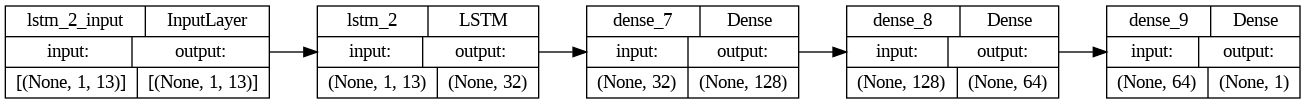

In [110]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [114]:
history = model.fit(x_train,y_train,epochs = 200, batch_size = 16, validation_data = (x_valid,y_valid), callbacks = my_callbacks)
p = history.history['loss']
print('-'*40)
print('\n')
# list all data in history
print(history.history.keys())

Epoch 1/200
322/322 [==============================] - 5s 8ms/step - loss: 312592138240.0000 - val_loss: 39854895104.0000
Epoch 2/200
 44/322 [===>..........................] - ETA: 1s - loss: 28569462784.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


322/322 [==============================] - 2s 6ms/step - loss: 10543493120.0000 - val_loss: 1796364288.0000
Epoch 3/200
322/322 [==============================] - 3s 9ms/step - loss: 1898868096.0000 - val_loss: 1233241728.0000
Epoch 4/200
322/322 [==============================] - 2s 7ms/step - loss: 1186066816.0000 - val_loss: 1330812928.0000
Epoch 5/200
322/322 [==============================] - 3s 10ms/step - loss: 1057345088.0000 - val_loss: 759126912.0000
Epoch 6/200
322/322 [==============================] - 2s 6ms/step - loss: 1051067200.0000 - val_loss: 751418432.0000
Epoch 7/200
322/322 [==============================] - 2s 6ms/step - loss: 842256960.0000 - val_loss: 1212387456.0000
Epoch 8/200
322/322 [==============================] - 3s 9ms/step - loss: 722760064.0000 - val_loss: 321441568.0000
Epoch 9/200
322/322 [==============================] - 2s 7ms/step - loss: 865187840.0000 - val_loss: 553872256.0000
Epoch 10/200
322/322 [==============================] - 2s 5ms/st

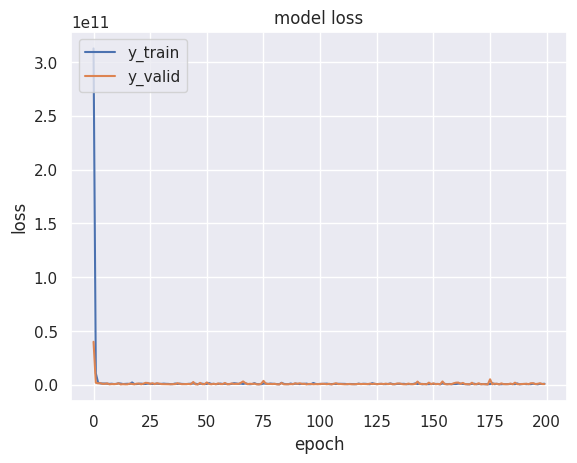

In [115]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['x_train', 'x_valid'], loc='upper left')
plt.legend(['y_train', 'y_valid'], loc='upper left')

In [116]:
preds_val = model.predict(x_valid)
preds_val = preds_val.squeeze()
result_val = y_valid - preds_val

101/101 [==============================] - 2s 5ms/step


In [117]:
preds_test = model.predict(x_test)
preds_test = preds_test.squeeze()
result_test = y_test - preds_val

101/101 [==============================] - 0s 4ms/step


In [118]:
def correlation_coefficient_var(y_valid, preds_coef_val):
    pearson_r_val = tfp.stats.correlation(preds_coef_val, y_valid)
    return(pearson_r_val)
    print(pearson_r_val)

In [119]:
def correlation_coefficient_test(y_test, preds_coef_test):
    pearson_r_test = tfp.stats.correlation(preds_coef_test, y_test)
    return(pearson_r_test)
    print(pearson_r_test)

print('-'*40)
print('\n')

----------------------------------------




In [120]:
preds_val = preds_val.reshape(-1, 1)
y_valid = y_valid.astype('float32')
print(correlation_coefficient_var(y_valid, preds_val))

tf.Tensor([[0.99922526]], shape=(1, 1), dtype=float32)


In [121]:
preds_test = preds_test.reshape(-1, 1)
y_test = y_test.astype('float32')
print(correlation_coefficient_test(y_test, preds_test))

tf.Tensor([[0.99917173]], shape=(1, 1), dtype=float32)


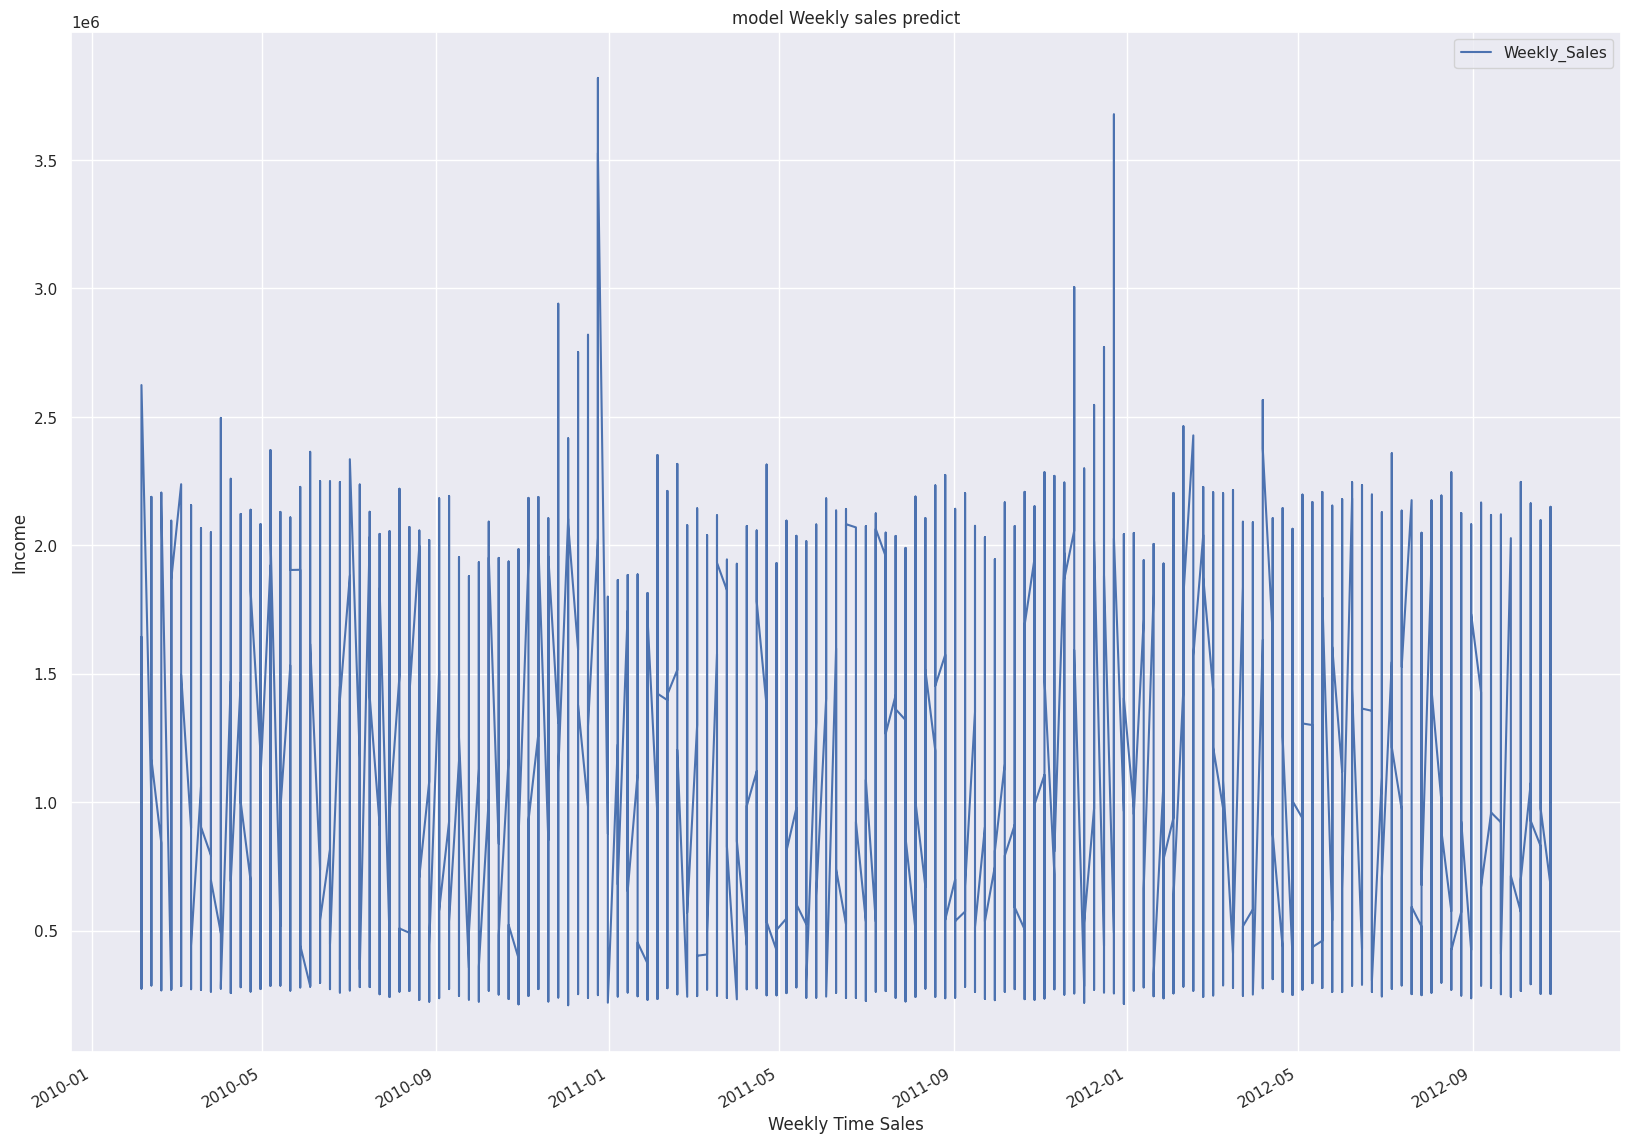

In [122]:
# Plotting the label prediction of sales.
Combind_graf = Combined_table.copy()
Combind_graf[['Weekly_Sales']].plot(subplots=True, figsize=(20,15))
plt.title('model Weekly sales predict')
plt.ylabel('Income')
plt.xlabel('Weekly Time Sales')
plt.show()

In [123]:
(print(preds_val))
corr, p_val = pearsonr(y_valid.squeeze(), preds_val.squeeze())
print('Pearson corr validation')
print(corr)
print('-'*40)
print('\n')

[[1970578.5]
 [1810345.9]
 [1304085.5]
 ...
 [ 296369.5]
 [1196404. ]
 [ 727123.9]]
Pearson corr validation
0.9992252735494481
----------------------------------------


